In [1]:
import os
import numpy as np
import tensorflow as tf
import pydicom
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img
import random
import matplotlib.pyplot as plt
import cv2
from skimage import exposure
from skimage.restoration import denoise_tv_chambolle
from skimage.util import view_as_windows
from PIL import Image
import pandas as pd
import os
import shutil
import pydicom
from PIL import Image
import numpy as np

<h1> Converting .dcm to .jpg </h1>

In [2]:
csv_file_path = '/Users/saadhviram/medical-deepfakes-lung-cancer/labels_exp1.csv'
csv_file_path_2 = '/Users/saadhviram/medical-deepfakes-lung-cancer/labels_exp2.csv'
source_dir = '/Users/saadhviram/medical-deepfakes-lung-cancer/CT_Scans/EXP1_blind'
source_dir_2 = '/Users/saadhviram/medical-deepfakes-lung-cancer/CT_Scans/EXP2_open'
destination_base_dir = '/Users/saadhviram/medical-deepfakes-lung-cancer/CT_Original_Lung/EXP1'
destination_base_dir_2 = '/Users/saadhviram/medical-deepfakes-lung-cancer/CT_Original_Lung/EXP2'
df = pd.read_csv(csv_file_path)
df_2 = pd.read_csv(csv_file_path_2)
#transfer(df,source_dir,destination_base_dir)
#transfer(df_2,source_dir_2,destination_base_dir_2)

In [3]:
def convert_dcm_to_jpg(dcm_file, jpg_file):
    ds = pydicom.dcmread(dcm_file)
    img_array = ds.pixel_array
    img_array = ((img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array)) * 255).astype(np.uint8)
    img = Image.fromarray(img_array)
    img.save(jpg_file)

In [4]:
def add_gaussian_noise(image, mean=0, var=0.05):
    gauss = np.random.normal(mean, var ** 0.5, image.shape)
    noisy = np.clip(image + gauss, 0, 255).astype(np.uint8)
    return noisy

In [5]:
def add_salt_and_pepper_noise(image, salt_prob=0.05, pepper_prob=0.05):
    noisy = np.copy(image)
    total_pixels = image.size
    num_salt = np.ceil(salt_prob * total_pixels)
    num_pepper = np.ceil(pepper_prob * total_pixels)
    salt_coords = [np.random.randint(0, i-1, int(num_salt)) for i in image.shape]
    noisy[salt_coords[0], salt_coords[1]] = 255
    pepper_coords = [np.random.randint(0, i-1, int(num_pepper)) for i in image.shape]
    noisy[pepper_coords[0], pepper_coords[1]] = 0
    return noisy

In [6]:
def add_poisson_noise(image):
    noisy = np.random.poisson(image)
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

In [7]:
def add_adversarial_like_noise(image, epsilon=0.01):
    noise = np.random.uniform(-epsilon, epsilon, image.shape)
    noisy = np.clip(image + noise, 0, 255).astype(np.uint8)
    return noisy

In [8]:
def load_image(image_path):
    image = Image.open(image_path).convert('L')
    return np.array(image)

def save_image(image_array, output_path):
    image = Image.fromarray(image_array)
    image.save(output_path)

In [11]:
image_path = '/Users/saadhviram/medical-deepfakes-lung-cancer/CT_Original_Lung/EXP1/FM/1005/135.jpg'
image_path_FB = '/Users/saadhviram/medical-deepfakes-lung-cancer/CT_Original_Lung/EXP1/FB/1009/115.jpg'
image_path_TB = '/Users/saadhviram/medical-deepfakes-lung-cancer/CT_Original_Lung/EXP1/TB/1531/105.jpg'
image_path_TM=  '/Users/saadhviram/medical-deepfakes-lung-cancer/CT_Original_Lung/EXP1/TM/1045/125.jpg'
output_path_gaussian = '/Users/saadhviram/medical-deepfakes-lung-cancer/gaussian_noisy_image.jpg'
output_path_salt_pepper = '/Users/saadhviram/medical-deepfakes-lung-cancer/salt_pepper_noisy_image.jpg'
output_path_poisson = '/Users/saadhviram/medical-deepfakes-lung-cancer/poisson_noisy_image.jpg'
output_path_adversarial = '/Users/saadhviram/medical-deepfakes-lung-cancer/adversarial_noisy_image.jpg'

In [12]:
image = load_image(image_path)
gaussian_noisy_image = add_gaussian_noise(image)
salt_pepper_noisy_image = add_salt_and_pepper_noise(image)
poisson_noisy_image = add_poisson_noise(image)
adversarial_noisy_image = add_adversarial_like_noise(image)

In [13]:
save_image(gaussian_noisy_image, output_path_gaussian)
save_image(salt_pepper_noisy_image, output_path_salt_pepper)
save_image(poisson_noisy_image, output_path_poisson)
save_image(adversarial_noisy_image, output_path_adversarial)

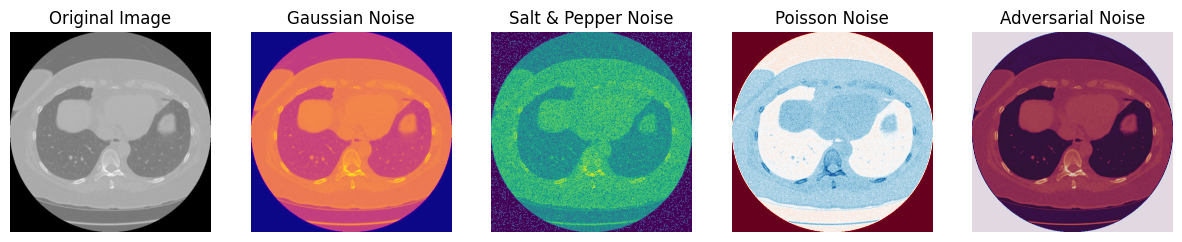

In [14]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(gaussian_noisy_image, cmap='plasma')
axes[1].set_title('Gaussian Noise')
axes[2].imshow(salt_pepper_noisy_image)
axes[2].set_title('Salt & Pepper Noise')
axes[3].imshow(poisson_noisy_image,cmap='RdBu')
axes[3].set_title('Poisson Noise')
axes[4].imshow(adversarial_noisy_image,cmap='twilight')
axes[4].set_title('Adversarial Noise')

for ax in axes:
    ax.axis('off')

plt.show()

**Original Image:** The image without any preprocessing.

**Gaussian Blur:** Smoothens the image by averaging the pixel values in a 5x5 kernel.

**Histogram Equalization:** Enhances contrast by redistributing the intensity histogram.

**Median Blur:** Reduces noise by replacing each pixel with the median value in a 5x5 kernel.

**Laplacian Edge Detection:** Highlights edges using the second derivative of the image.

**Sobel X Gradient:** Detects edges in the horizontal direction.

**Sobel Y Gradient:** Detects edges in the vertical direction.

**CLAHE:** Similar to histogram equalization but operates on small regions to improve contrast adaptively.

**Adaptive Thresholding:** Binarizes the image based on local intensity variations.

**Sharpening Filter:** Increases the sharpness of the image by enhancing edges.

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image):
    original = image
    gb_img = cv2.GaussianBlur(image, (5, 5), 0)
    hist_equ = cv2.equalizeHist(image)
    median_blur = cv2.medianBlur(image, 5)
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    laplacian = cv2.convertScaleAbs(laplacian)
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_x = cv2.convertScaleAbs(sobel_x)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    sobel_y = cv2.convertScaleAbs(sobel_y)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(image)
    adaptive_thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 11, 2)
    kernel_sharpen = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
    sharpened = cv2.filter2D(image, -1, kernel_sharpen)
    return [original, gb_img, hist_equ, median_blur, laplacian, sobel_x, sobel_y, clahe_img, adaptive_thresh, sharpened]


In [16]:
def Display(image):
  image_g = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
  preprocessed_images = preprocess_image(image_g)
  titles = ['Original', 'Gaussian Blur', 'Histogram Equalization', 'Median Blur', 'Laplacian', 'Sobel X', 'Sobel Y', 'CLAHE', 'Adaptive Threshold', 'Sharpened']
  fig, axes = plt.subplots(2, 5, figsize=(20, 8))
  for i, ax in enumerate(axes.flat):
    ax.imshow(preprocessed_images[i], cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')
  plt.show()

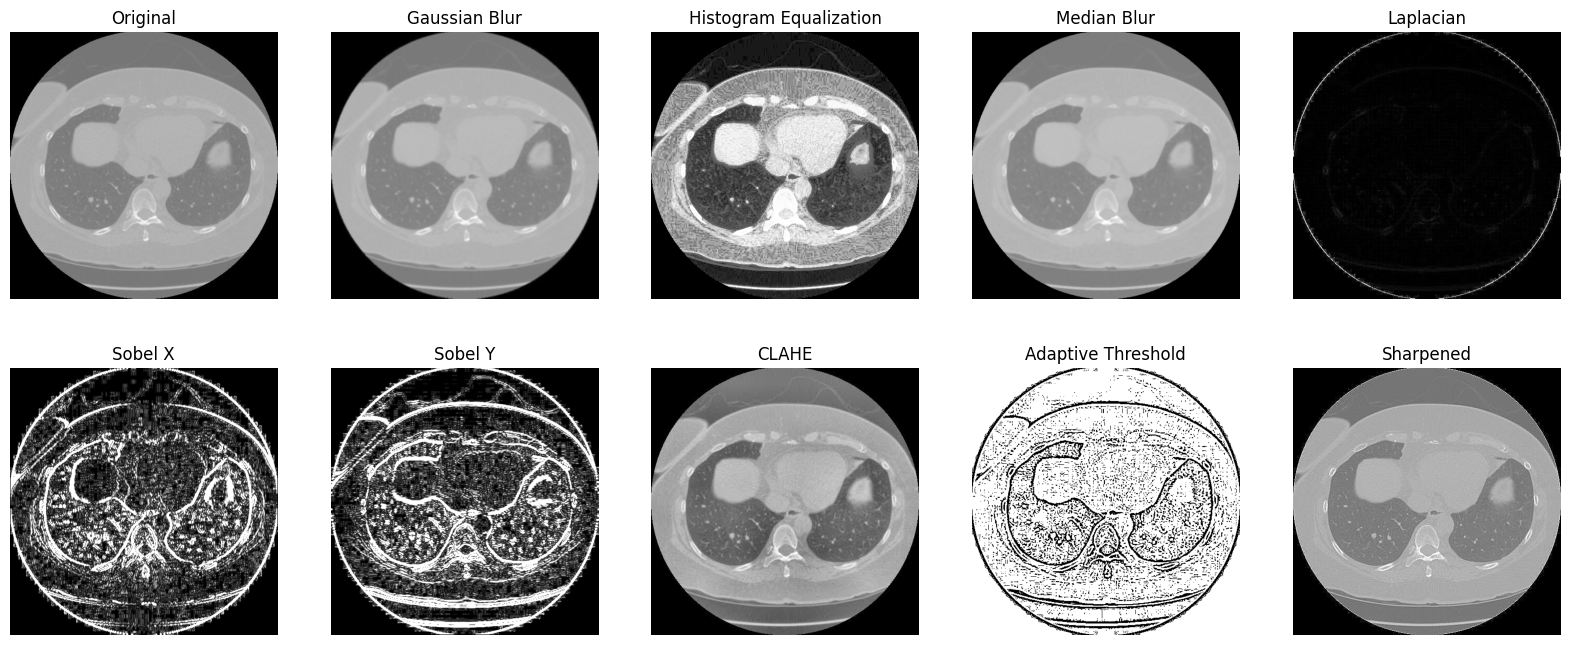

In [17]:
Display(image_path) #FM

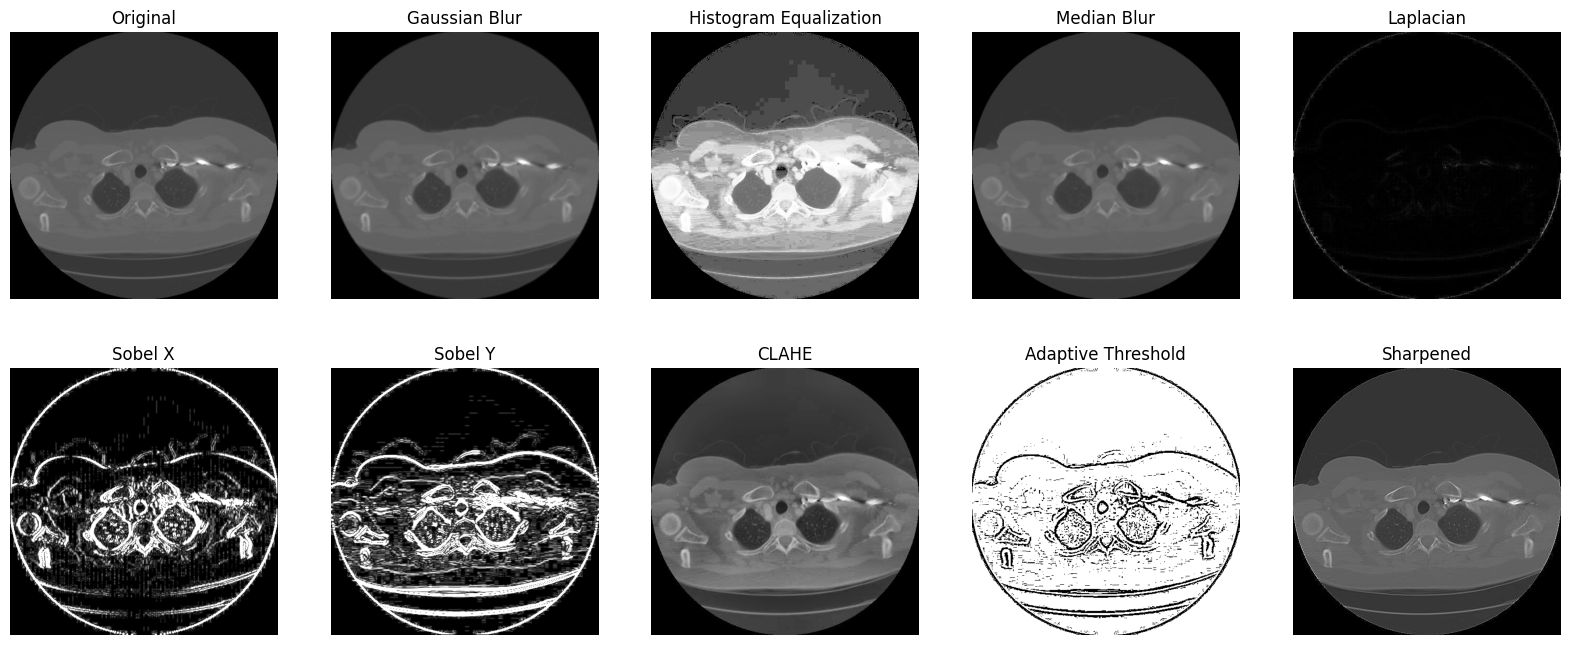

In [18]:
Display(image_path_FB) #FB

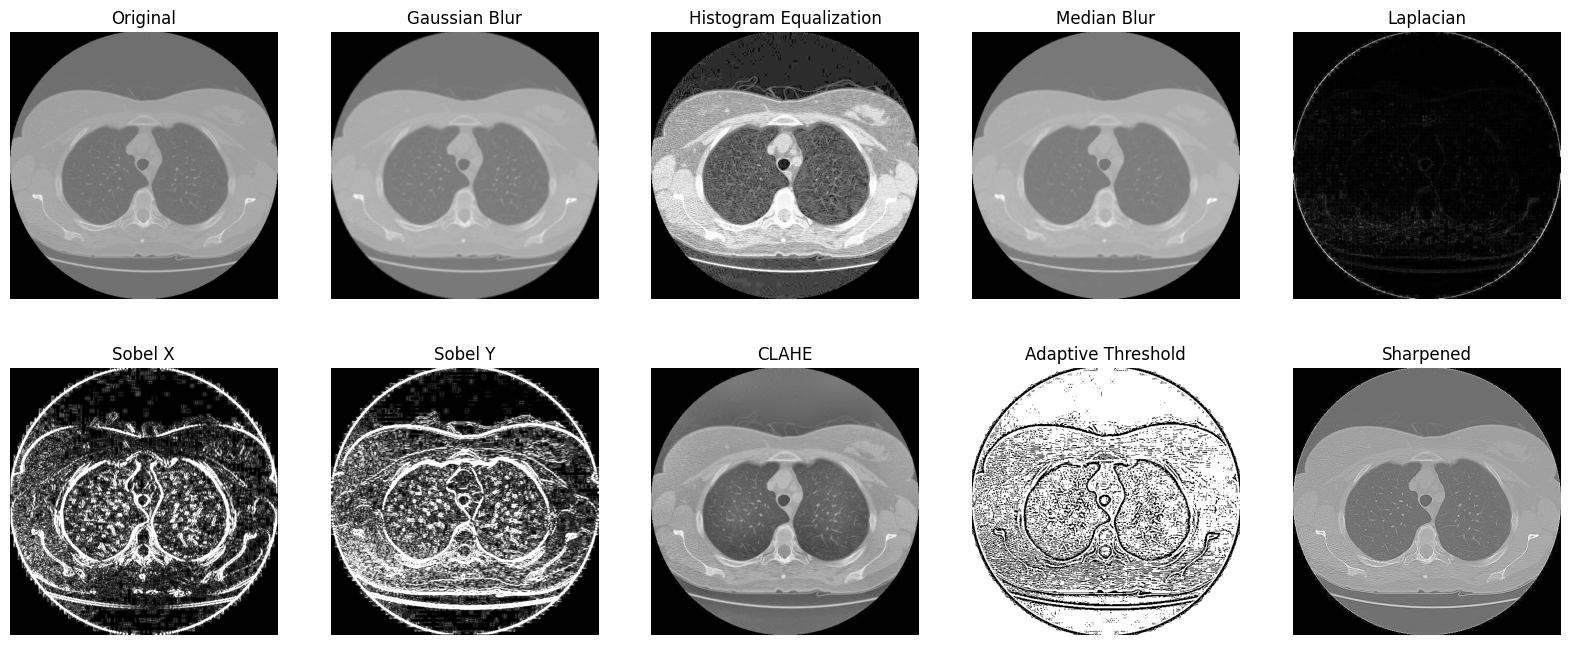

In [19]:
Display(image_path_TB) #TB

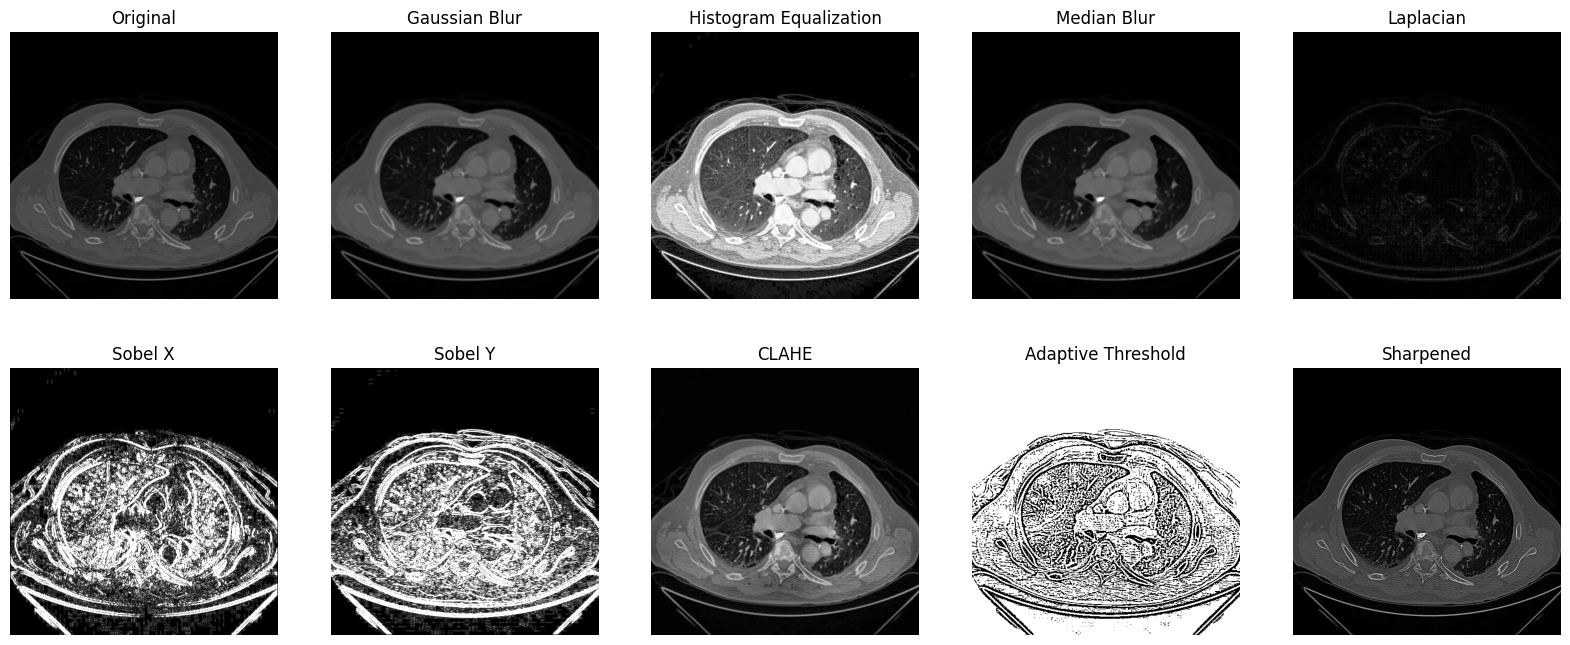

In [20]:
Display(image_path_TM) #TM

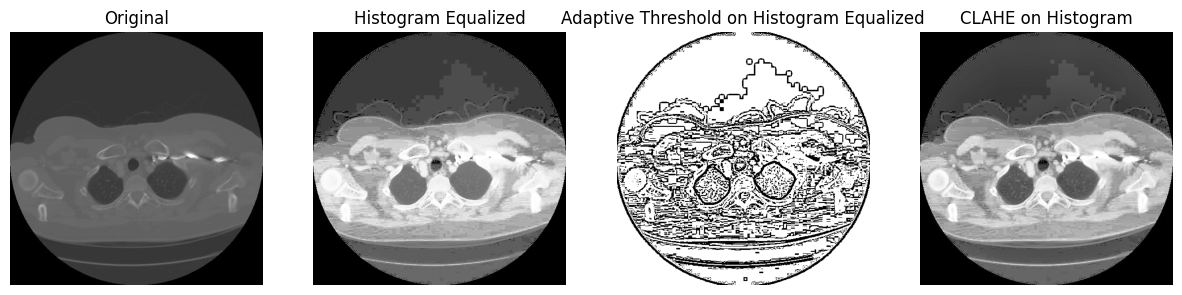

In [24]:
def preprocess_image(image):
    original = image
    hist_equ = cv2.equalizeHist(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(hist_equ)
    adaptive_thresh_on_hist = cv2.adaptiveThreshold(hist_equ, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 11, 2)
    return [original,hist_equ,adaptive_thresh_on_hist,clahe_img]

image = cv2.imread(image_path_FB, cv2.IMREAD_GRAYSCALE)
preprocessed_images = preprocess_image(image)
titles = ['Original', 'Histogram Equalized', 'Adaptive Threshold on Histogram Equalized','CLAHE on Histogram']
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(preprocessed_images[i], cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')
plt.show()

In [1]:
def transfer(dir,source_dir,destination_base_dir):
  for index, row in dir.iterrows():
    file_type = str(row['type'])
    uuid = str(row['uuid'])
    slice_name = str(row['slice']) + ".dcm"

    # Create the destination directory if it doesn't exist
    destination_dir = os.path.join(destination_base_dir, file_type, uuid)
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Find all DICOM files in the source directory corresponding to the uuid
    uuid_dir = os.path.join(source_dir, uuid)
    if os.path.exists(uuid_dir):
        for file in os.listdir(uuid_dir):
            if file.endswith(".dcm"):
                source_file = os.path.join(uuid_dir, file)
                destination_file_jpg = os.path.join(destination_dir, f"{os.path.splitext(file)[0]}.jpg")

                # Debugging: Print paths to ensure they are correct
                #print(f"Source file: {source_file}")
                #print(f"Destination file: {destination_file_jpg}")

                # Convert the DICOM file to JPG and save it in the destination directory
                if os.path.isfile(source_file):
                    convert_dcm_to_jpg(source_file, destination_file_jpg)
                else:
                    print(f"Warning: {source_file} is not a file or does not exist.")
    else:
        print(f"Warning: Directory {uuid_dir} does not exist.")
  print("Files have been converted and organized successfully.")

In [ ]:
csv_file_path = '/Users/saadhviram/medical-deepfakes-lung-cancer/labels_exp1.csv'
csv_file_path_2 = '/Users/saadhviram/medical-deepfakes-lung-cancer/labels_exp2.csv'
source_dir = '/Users/saadhviram/medical-deepfakes-lung-cancer/CT_Scans/EXP1_blind'
source_dir_2 = '/Users/saadhviram/medical-deepfakes-lung-cancer/CT_Scans/EXP2_open'
destination_base_dir = '/Users/saadhviram/medical-deepfakes-lung-cancer/CT_Original_Lung/EXP1'
destination_base_dir_2 = '/Users/saadhviram/medical-deepfakes-lung-cancer/CT_Original_Lung/EXP2'
df = pd.read_csv(csv_file_path)
df_2 = pd.read_csv(csv_file_path_2)
transfer(df,source_dir,destination_base_dir)
transfer(df_2,source_dir_2,destination_base_dir_2)

In [ ]:
# Define paths for experiments, classes, and output
experiment_dirs = ['/Users/saadhviram/medical-deepfakes-lung-cancer/CT_Original_Lung/EXP1', '/Users/saadhviram/medical-deepfakes-lung-cancer/CT_Original_Lung/EXP2']
class_labels = ['FB', 'FM', 'TB', 'TM']
output_train_dir = '/Users/saadhviram/medical-deepfakes-lung-cancer/CT_preprocessed_Lung/train'
output_test_dir = '/Users/saadhviram/medical-deepfakes-lung-cancer/CT_preprocessed_Lung/test'

In [ ]:
# Create directories for preprocessed train, validation, and test data
os.makedirs(output_train_dir, exist_ok=True)
os.makedirs(output_test_dir, exist_ok=True)
for label in class_labels:
    os.makedirs(os.path.join(output_train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(output_test_dir, label), exist_ok=True)

In [ ]:
def preprocess_image(image, i):
    hist_equ = cv2.equalizeHist(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(hist_equ)
    adaptive_thresh_on_hist = cv2.adaptiveThreshold(hist_equ, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    return [hist_equ, adaptive_thresh_on_hist, clahe_img][i]

In [ ]:
# Function to process and save preprocessed images
def process_and_save_image_slices(scan_dir, label, output_dir):
    for img_file in os.listdir(scan_dir):
        img_path = os.path.join(scan_dir, img_file)
        if os.path.isfile(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            preprocessed_img = preprocess_image(img, 2)
            preprocessed_pil_img = Image.fromarray(preprocessed_img)
            output_slice_dir = os.path.join(output_dir, label, os.path.basename(scan_dir))
            os.makedirs(output_slice_dir, exist_ok=True)
            output_path = os.path.join(output_slice_dir, img_file)
            preprocessed_pil_img.save(output_path)

In [ ]:
def preprocess_function():
    from sklearn.model_selection import train_test_split
    # Collect all scan directories and labels
    scan_dirs = []
    labels = []

    for experiment_dir in experiment_dirs:
        for label in class_labels:
            class_dir = os.path.join(experiment_dir, label)
            for scan_dir in os.listdir(class_dir):
                scan_dirs.append(os.path.join(class_dir, scan_dir))
                labels.append(label)

    # Split the dataset into training and testing sets (80/20 split here)
    train_dirs, test_dirs, train_labels, test_labels = train_test_split(
        scan_dirs, labels, test_size=0.2, stratify=labels, random_state=42
    )

    # Process and save preprocessed image slices for train and test sets
    for scan_dir, label in zip(train_dirs, train_labels):
        process_and_save_image_slices(scan_dir, label, output_train_dir)

    for scan_dir, label in zip(test_dirs, test_labels):
        process_and_save_image_slices(scan_dir, label, output_test_dir)

    print("Preprocessing complete. Train and test data saved.")

preprocess_function()